<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Посмотрим на какую-нибудь картинку:

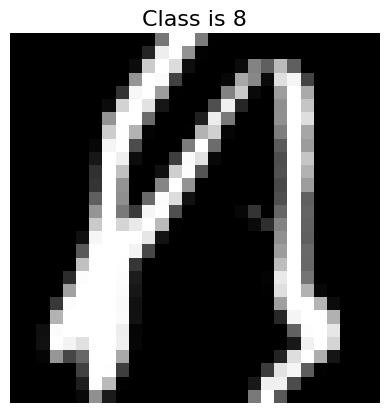

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





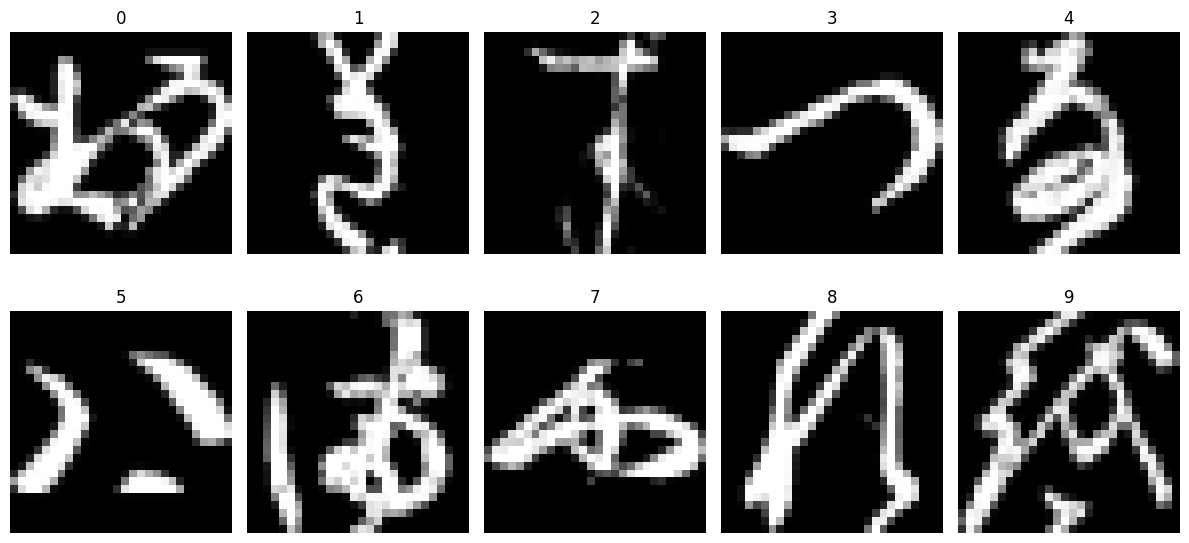

In [5]:
images = trainset.data.numpy()
labels = trainset.targets.numpy()

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axs = axs.flatten()

for i in range(10):
    img = images[labels == i][0]
    axs[i].imshow(img, cmap = "grey")
    axs[i].set_title(f"{i}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [6]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [7]:
print(f'Количество весов: {28*28*256 + 256*128 + 128*10}')
print(f'Смещений: {256+128+10}')

Количество весов: 234752
Смещений: 394


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [8]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [9]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [10]:
n_epochs = 10
loss_history = []

for i in range(n_epochs):
    i_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        i_loss += loss.item()

    loss_history.append(i_loss/len(trainloader))
    print(f"Epoch {i+1} loss={loss_history[i]:.4f}")

Epoch 1 loss=0.9029
Epoch 2 loss=0.4498
Epoch 3 loss=0.3577
Epoch 4 loss=0.2979
Epoch 5 loss=0.2569
Epoch 6 loss=0.2210
Epoch 7 loss=0.1912
Epoch 8 loss=0.1692
Epoch 9 loss=0.1476
Epoch 10 loss=0.1307


In [11]:
get_accuracy(fc_net, testloader)

0.8765

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [12]:
mean = trainset.data.float().mean() / 255
std = trainset.data.float().std() / 255
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [13]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [14]:
n_epochs = 10
loss_history = []

for i in range(n_epochs):
    i_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        i_loss += loss.item()

    loss_history.append(i_loss/len(trainloader))
    print(f"Epoch {i+1} loss={loss_history[i]:.4f}")


Epoch 1 loss=0.6880
Epoch 2 loss=0.3081
Epoch 3 loss=0.2254
Epoch 4 loss=0.1757
Epoch 5 loss=0.1412
Epoch 6 loss=0.1136
Epoch 7 loss=0.0926
Epoch 8 loss=0.0765
Epoch 9 loss=0.0629
Epoch 10 loss=0.0516


In [15]:
get_accuracy(fc_net, testloader)

0.8946

Как изменилась `accuracy` после нормализации?

Слегка увеличилась

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [16]:
class FCNet_activation(FCNet):
    def __init__(self, activation_func):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation_func()

    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

In [22]:
loss_function = nn.CrossEntropyLoss()

act_func = [nn.ReLU, nn.Sigmoid, nn.GELU, nn.Tanh]

for i in range(0, 4):
  print(f'Activation function is {act_func[i].__name__}')
  net_act = FCNet_activation(act_func[i])
  optimizer = torch.optim.Adam(net_act.parameters(), lr=3e-4)
  for epoch in range(n_epochs):
      i_loss = 0
      for images, labels in trainloader: 
          optimizer.zero_grad() 
          outputs = net_act(images) 
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          
          i_loss += loss.item()

      loss_history[i].append(i_loss/len(trainloader))
      print(f"Epoch {epoch+1} loss {loss_history[i][epoch]:.4f}")

  print(f'accuracy of {act_func[i].__name__}', get_accuracy(net_act, testloader))

Activation function is ReLU
Epoch 1 loss 0.6839
Epoch 2 loss 0.3044
Epoch 3 loss 0.2229
Epoch 4 loss 0.1737
Epoch 5 loss 0.1396
Epoch 6 loss 0.1130
Epoch 7 loss 0.0927
Epoch 8 loss 0.0765
Epoch 9 loss 0.0630
Epoch 10 loss 0.0497
accuracy of ReLU 0.9016
Activation function is Sigmoid
Epoch 1 loss 1.5409
Epoch 2 loss 0.7557
Epoch 3 loss 0.5502
Epoch 4 loss 0.4475
Epoch 5 loss 0.3761
Epoch 6 loss 0.3223
Epoch 7 loss 0.2788
Epoch 8 loss 0.2433
Epoch 9 loss 0.2135
Epoch 10 loss 0.1890
accuracy of Sigmoid 0.8549
Activation function is GELU
Epoch 1 loss 0.6591
Epoch 2 loss 0.2819
Epoch 3 loss 0.2038
Epoch 4 loss 0.1551
Epoch 5 loss 0.1219
Epoch 6 loss 0.0967
Epoch 7 loss 0.0774
Epoch 8 loss 0.0627
Epoch 9 loss 0.0493
Epoch 10 loss 0.0385
accuracy of GELU 0.9055
Activation function is Tanh
Epoch 1 loss 0.7768
Epoch 2 loss 0.3827
Epoch 3 loss 0.2574
Epoch 4 loss 0.1850
Epoch 5 loss 0.1377
Epoch 6 loss 0.1047
Epoch 7 loss 0.0794
Epoch 8 loss 0.0590
Epoch 9 loss 0.0434
Epoch 10 loss 0.0330
accura

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Наибольшее значение accuracy у GeLu

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [24]:
from torch.optim import Adam, Adagrad, RMSprop
loss_history = [[], [], []]
opt_func = [Adam, Adagrad, RMSprop]

for i in range(0, 3):
  print(f'Optimisation function is {opt_func[i].__name__}')
  net_opt = FCNet_activation(nn.GELU)
  optimizer = opt_func[i](net_opt.parameters(), lr=3e-4)
  for epoch in range(n_epochs):
      i_loss = 0
      for images, labels in trainloader: 
          optimizer.zero_grad() 
          outputs = net_opt(images) 
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          
          i_loss += loss.item()

      loss_history[i].append(i_loss/len(trainloader))
      print(f"Epoch {epoch+1} loss {loss_history[i][epoch]:.4f}")

  print(f'accuracy of {opt_func[i].__name__}', get_accuracy(net_opt, testloader))

Optimisation function is Adam
Epoch 1 loss 0.6603
Epoch 2 loss 0.2792
Epoch 3 loss 0.2024
Epoch 4 loss 0.1542
Epoch 5 loss 0.1211
Epoch 6 loss 0.0977
Epoch 7 loss 0.0787
Epoch 8 loss 0.0630
Epoch 9 loss 0.0511
Epoch 10 loss 0.0398
accuracy of Adam 0.9013
Optimisation function is Adagrad
Epoch 1 loss 1.3391
Epoch 2 loss 0.8156
Epoch 3 loss 0.6946
Epoch 4 loss 0.6337
Epoch 5 loss 0.5944
Epoch 6 loss 0.5661
Epoch 7 loss 0.5440
Epoch 8 loss 0.5263
Epoch 9 loss 0.5107
Epoch 10 loss 0.4976
accuracy of Adagrad 0.7229
Optimisation function is RMSprop
Epoch 1 loss 0.4396
Epoch 2 loss 0.2374
Epoch 3 loss 0.1749
Epoch 4 loss 0.1345
Epoch 5 loss 0.1053
Epoch 6 loss 0.0838
Epoch 7 loss 0.0662
Epoch 8 loss 0.0519
Epoch 9 loss 0.0401
Epoch 10 loss 0.0310
accuracy of RMSprop 0.9034


Adam и RMSprop показывают схожие результаты

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [25]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):

        zeros = torch.zeros(x.shape)
        x[x < zeros] = 0
        
        return x


Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [34]:
class FCNet_cust(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  
        x = x.view(-1, 784) 
        x = self.fc1(x)
        x = CustomReLU()(x)
        x = self.fc2(x)
        x = CustomReLU()(x)
        x = self.fc3(x)
        
        return CustomReLU()(x)

loss_history = []
n_epochs = 10

fc_net_cust = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net_cust.parameters())

for i in range(n_epochs):
    i_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net_cust(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        i_loss += loss.item()

    loss_history.append(i_loss/len(trainloader))
    print(f"Epoch {i+1} loss={loss_history[i]:.4f}")


print(f"accuracy={get_accuracy(fc_net_cust, testloader)}.")

Epoch 1 loss=0.4638
Epoch 2 loss=0.1894
Epoch 3 loss=0.1256
Epoch 4 loss=0.0879
Epoch 5 loss=0.0624
Epoch 6 loss=0.0447
Epoch 7 loss=0.0320
Epoch 8 loss=0.0237
Epoch 9 loss=0.0191
Epoch 10 loss=0.0205
accuracy=0.9027.


### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Телеграм бот не захотел со мной общаться, поэтому я воспользовалась сайтом (https://rudalle.ru/demo). Вот, что получилось:

## Ночь в музее Якубовича
![](https://sun9-7.userapi.com/impg/ebcf73T8YKWSd9cAKhG5uVqiL6gDf9MJ0Rwnyw/oE6Nw3wJGns.jpg?size=1024x1024&quality=95&sign=4eaa6f23e784d797c589ff29a32e74f7&type=album)

## Лабораторная мышь (крадется)
![](https://sun9-61.userapi.com/impg/P39ODZFHP3PySFsYqPA7Vt8559hkkSM6ySpeMg/RBthl597Rh8.jpg?size=1024x1024&quality=95&sign=8562a4d4963400ee93bd121ee3265021&type=album)

## Нейронные рыбы (привет из каламбурошной)
![](https://sun9-38.userapi.com/impg/C4RYry9tgukVs8AwueQqiWOB_XtkFlQ5aoo1YA/aLRDekXkF_M.jpg?size=1024x1024&quality=95&sign=349fa5f47b6d0b6e1ea0418ed606c366&type=album)


Также поигралась с  Kandinsky 2.2
Узрите! Мокрая биология

![](https://sun9-4.userapi.com/impg/FmtaE8XWKi0CMWofq2uKxOG6mk9PJOtTqbKVCw/dkA5X4yj5ik.jpg?size=512x512&quality=95&sign=43f7944be16d50d244204174d6555296&type=album)